# Project 1

Authors: Lucas and Ari

## Introduction

In this project, we're going to analyze a flight route network and identify which airlines serve which markets. For this, we're going to build a network where airports are the nodes, routes are the edge, and airlines are a node feature, meaning an airline flies off that airport. Airports get an edge if airport $j$ and $i$ share a route.

## Load Packages and Data

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from scipy import stats

routes = pd.read_csv('https://raw.githubusercontent.com/lucasweyrich958/DATA620/refs/heads/main/routes.csv')

print(routes.head())

   index Airline Airline ID Source airport Source airport ID  \
0      0      2B        410            AER              2965   
1      1      2B        410            ASF              2966   
2      2      2B        410            ASF              2966   
3      3      2B        410            CEK              2968   
4      4      2B        410            CEK              2968   

  Destination airport Destination airport ID Codeshare  Stops Equipment  
0                 KZN                   2990       NaN      0       CR2  
1                 KZN                   2990       NaN      0       CR2  
2                 MRV                   2962       NaN      0       CR2  
3                 KZN                   2990       NaN      0       CR2  
4                 OVB                   4078       NaN      0       CR2  


## Build Graph

After loading the data set, we're going to build a network graph. Since we have source and destination airport information, we're going to build a directed graph. We're going to build nodes out of all unique airport codes from both columns, and then add nodes if an airline serves two nodes.

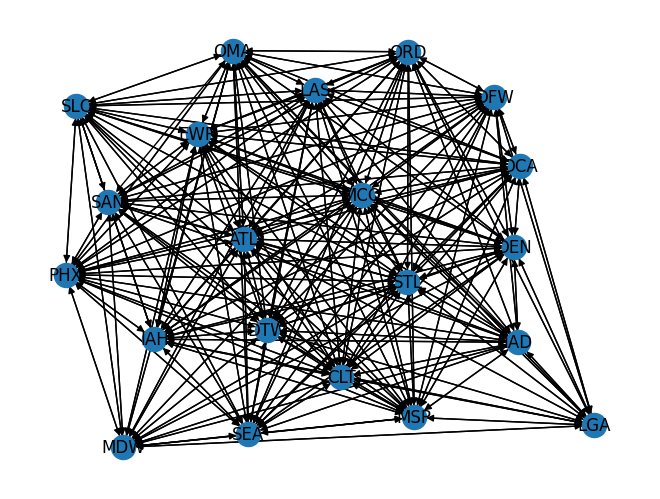

In [3]:
#Build directed graph
G = nx.DiGraph()

#Add nodes (unique airports)
all_airports = pd.concat([routes['Source airport'], routes['Destination airport']]).unique()
G.add_nodes_from(all_airports)

#Add edges (flight routes)
for index, row in routes.iterrows():
    source_id = row['Source airport']
    destination_id = row['Destination airport']
    G.add_edge(source_id, destination_id)

#Using set to avoid duplicates
airport_serving_airlines = defaultdict(set)

for index, row in routes.iterrows():
    source_id = row['Source airport']
    destination_id = row['Destination airport']
    airline = row['Airline']
    airport_serving_airlines[source_id].add(airline) #Add the airline to the set of airlines serving the source airport
    airport_serving_airlines[destination_id].add(airline) #Add the airline to the set of airlines serving the destination airport

#Assign the set of airlines as a node attribute
for airport_id, airlines_set in airport_serving_airlines.items():
    G.nodes[airport_id]['serving_airlines'] = list(airlines_set)

#Show a sample of the graph w/ one small airport & its connected nodes
airport = 'OMA'
neighbors = set(G.successors(airport)) | set(G.predecessors(airport))
neighbors.add(airport)
H = G.subgraph(neighbors)
nx.draw(H, with_labels=True)


## Network Measures

We're going to calculate degree centrality, eigenvector centrality, and betweenness centrality. Because we have a directed graph we must calculate the sum of the inbound and outbound measures.

* Degree Centrality - node with the most connections; shows airports or airlines with the most flights in and out
* Eigenvector Centrality - node connected to other well-connected/"important" nodes; shows major influential airports
* Betweenness Centrality - node that appears most on shortest paths; highlights major layover hubs or connectors between airports

Then, we can assess these measures for select airports if we choose so. In this case, we're selecting a small-sized, medium-sized and two large sized airports. Omaha, St. Louis, Atlanta, and New York JFK respectively.

In [4]:
#Degree centrality
total_degree_centrality = {node: G.in_degree(node) + G.out_degree(node) for node in G.nodes()}

#Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

#Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

#Store centrality measures as node attributes
for node in G.nodes():
    G.nodes[node]['total_degree_centrality'] = total_degree_centrality.get(node, 0)
    G.nodes[node]['eigenvector_centrality'] = eigenvector_centrality.get(node, 0)
    G.nodes[node]['betweenness_centrality'] = betweenness_centrality.get(node, 0)

#Print measures for select airports
selected_airports = ['OMA', 'STL', 'ATL', 'JFK']

for airport_code in selected_airports:
    if airport_code in G:
        node_attributes = G.nodes[airport_code]
        print(f"Airport: {airport_code}")
        print(f"  Serving Airlines: {node_attributes.get('serving_airlines', 'N/A')}")
        print(f"  Total Degree Centrality: {node_attributes['total_degree_centrality']:.4f}")
        print(f"  Eigenvector Centrality: {node_attributes['eigenvector_centrality']:.4f}")
        print(f"  Betweenness Centrality: {node_attributes['betweenness_centrality']:.4f}")
        print("-" * 30)

Airport: OMA
  Serving Airlines: ['AA', 'AZ', 'US', 'FL', 'WN', 'KL', 'AF', 'UA', 'F9', 'AS', 'DL']
  Total Degree Centrality: 38.0000
  Eigenvector Centrality: 0.0147
  Betweenness Centrality: 0.0000
------------------------------
Airport: STL
  Serving Airlines: ['AA', 'AZ', 'US', 'VS', 'AM', 'FL', 'KL', 'WN', '3E', 'AF', 'UA', '9K', 'AC', 'F9', 'AS', 'DL']
  Total Degree Centrality: 121.0000
  Eigenvector Centrality: 0.0313
  Betweenness Centrality: 0.0042
------------------------------
Airport: ATL
  Serving Airlines: ['NZ', 'JL', 'FL', 'AC', 'F9', 'AZ', 'US', 'QF', 'SU', 'VA', 'AF', 'CI', 'MH', 'UA', 'NK', 'BA', 'CA', 'LH', 'QR', 'AM', 'WN', 'NH', 'TK', '9E', 'AA', 'EI', 'IB', 'EY', 'OZ', 'CX', 'VS', 'KE', 'KL', '3M', 'AY', 'WS', 'AS', 'DL']
  Total Degree Centrality: 433.0000
  Eigenvector Centrality: 0.0813
  Betweenness Centrality: 0.0294
------------------------------
Airport: JFK
  Serving Airlines: ['AI', 'BW', 'CM', 'JL', 'OJ', 'AB', 'SQ', 'FI', 'HY', 'VX', 'AC', 'PK', 'ET'

As we can see, the total degree centrality is lowest for the small sized airport, Omaha, followed by St. Louis as the medium sized airport. However, even though JFK has more airlines serving, Atlanta has a higher degree centrality. That is because ATL is the main hub for Delta, one of the biggest airlines in the world. JFK is not a hub per se, hence, ATL is connected to more nodes than JFK is.

On the other hand, looking at eigenvector centrality, JFK actually a higher centrality than ATL. The higher degree centrality means ATL has more connections but JFK's higher eigenvector centrality means its connections are more highly connected/influential. This is because JFK sits on a coast and acts as a hub for a lot of international flights into the USA so it connects with a lot of major global airlines like Emirates and British Airways.

Betweenness centrality gives us a look into how important these airports are as a connector between other airports or a layover hub. We can see very clearly with its 0.0 that the small sized airport, OMA, is not used at all as a connector. If you're flying in or out of OMA, it's most likely your final destination. STL's slightly higher but really the other two, ATL and JFK, are the two standing out as major connecting hubs like outlined above due to their connections with Delta in ATL and international flights in JFK.


This begs the question of assessing airlines more closely as well. For the current example, we're going to compare the three major US airlines. Delta, American Airlines, and United. We're computing the average centralities of their airports, and then use a one-way ANOVA to compare the three averages.

In [7]:
#Compare Centrality for DL, AA, and UA
selected_airlines = ['DL', 'AA', 'UA']
airline_groups_degree_centrality = defaultdict(list)
airline_groups_eigenvector_centrality = defaultdict(list)
airline_groups_betweenness_centrality = defaultdict(list)

for node, attributes in G.nodes(data=True):
    if 'serving_airlines' in attributes:
        for airline in attributes['serving_airlines']:
            if airline in selected_airlines:
                airline_groups_degree_centrality[airline].append(attributes['total_degree_centrality'])
                airline_groups_eigenvector_centrality[airline].append(attributes['eigenvector_centrality'])
                airline_groups_betweenness_centrality[airline].append(attributes['betweenness_centrality'])

#print(f"Centrality Measures for {', '.join(selected_airlines)}")

for airline in selected_airlines:
    avg_degree = np.mean(airline_groups_degree_centrality[airline])
    avg_betweenness = np.mean(airline_groups_betweenness_centrality[airline])
    avg_eigenvector = np.mean(airline_groups_eigenvector_centrality[airline])
    print(f"Centrality Measures for {airline}:")
    print(f"  Average Total Degree Centrality = {avg_degree:.4f} (N={len(airline_groups_degree_centrality[airline])})")
    print(f"  Average Total Eigenvector Centrality = {avg_eigenvector:.4f} (N={len(airline_groups_eigenvector_centrality[airline])})")
    print(f"  Average Total Betweenness Centrality = {avg_betweenness:.4f} (N={len(airline_groups_betweenness_centrality[airline])})")


#Compute ANOVAs
anova_data = []
group_labels = []

for airline in selected_airlines:
    anova_data.append(airline_groups_degree_centrality[airline])
    group_labels.append(airline)

f_statistic, p_value = stats.f_oneway(*anova_data)
print(f"\nOne-Way ANOVA for Degree Centrality: {', '.join(selected_airlines)}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")


anova_data_betweenness = []
for airline in selected_airlines:
    anova_data_betweenness.append(airline_groups_betweenness_centrality[airline])

f_statistic_betweenness, p_value_betweenness = stats.f_oneway(*anova_data_betweenness)
print(f"\nOne-Way ANOVA for Betweenness Centrality: {', '.join(selected_airlines)}")
print(f"F-statistic: {f_statistic_betweenness:.4f}")
print(f"P-value: {p_value_betweenness:.4f}")

anova_data_eigenvector = []
for airline in selected_airlines:
    anova_data_eigenvector.append(airline_groups_eigenvector_centrality[airline])

f_statistic_eigenvector, p_value_eigenvector = stats.f_oneway(*anova_data_eigenvector)
print(f"\nOne-Way ANOVA for Eigenvector Centrality: {', '.join(selected_airlines)}")
print(f"F-statistic: {f_statistic_eigenvector:.4f}")
print(f"P-value: {p_value_eigenvector:.4f}")

Centrality Measures for DL:
  Average Total Degree Centrality = 79.5706 (N=354)
  Average Total Eigenvector Centrality = 0.0233 (N=354)
  Average Total Betweenness Centrality = 0.0050 (N=354)
Centrality Measures for AA:
  Average Total Degree Centrality = 79.6567 (N=434)
  Average Total Eigenvector Centrality = 0.0247 (N=434)
  Average Total Betweenness Centrality = 0.0047 (N=434)
Centrality Measures for UA:
  Average Total Degree Centrality = 70.5972 (N=432)
  Average Total Eigenvector Centrality = 0.0212 (N=432)
  Average Total Betweenness Centrality = 0.0043 (N=432)

One-Way ANOVA for Degree Centrality: DL, AA, UA
F-statistic: 1.1673
P-value: 0.3116

One-Way ANOVA for Betweenness Centrality: DL, AA, UA
F-statistic: 0.3885
P-value: 0.6782

One-Way ANOVA for Eigenvector Centrality: DL, AA, UA
F-statistic: 1.3118
P-value: 0.2697


All three centralities for the three airlines appears to be quite similar, as the ANOVA confirms with $p$ values between 0.26 and 0.67, it is not significantly different. Therefore, it appears that the three major airlines have about similarly connected number of nodes, importance of nodes and connectors, with United having a bit less in all three categories.

This leads to the conclusion that it should not matter, on average, which airlines one takes to get to a destination within the US.